Running scenario: baseline

Scenario: baseline
{'patient_log_rep_stats': {'scenario': 'baseline', 'patient_log_rep_stats': {}, 'patient_log_ci':              wait_for_registration  wait_for_triage_nurse  wait_for_triage  wait_for_treatment  time_in_system
mean                           0.0                163.665          354.962              18.532         616.367
std                            0.0                 28.929           64.997               5.272         101.284
ci_95_lower                    0.0                155.646          336.946              17.071         588.293
ci_95_upper                    0.0                171.683          372.979              19.993         644.442
n_samples                     50.0                 50.000           50.000              50.000          50.000}}
{}
95th percentile of time in system: 1028.1 mins


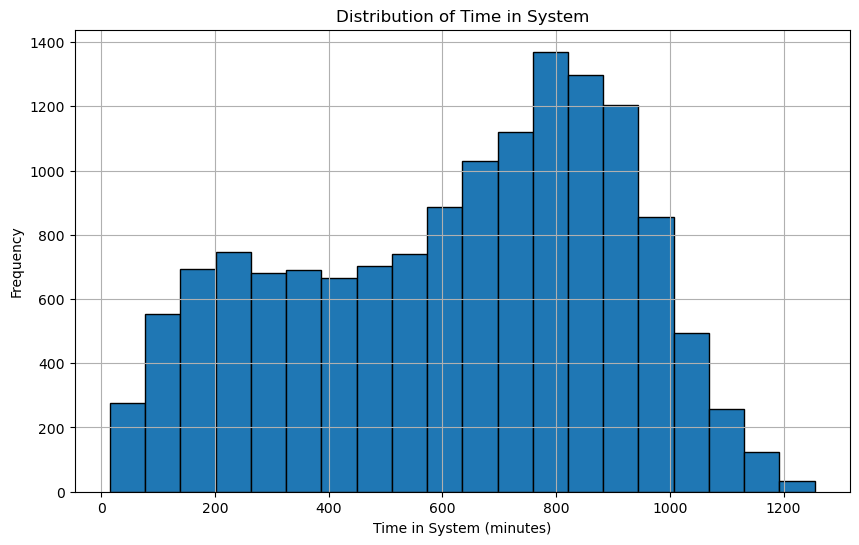

Finished scenario: baseline
Running scenario: a4n20d10

Scenario: a4n20d10
{'patient_log_rep_stats': {'scenario': 'a4n20d10', 'patient_log_rep_stats': {}, 'patient_log_ci':              wait_for_registration  wait_for_triage_nurse  wait_for_triage  wait_for_treatment  time_in_system
mean                           0.0                  3.568           10.302               5.116          84.157
std                            0.0                  0.781            1.631               0.206           3.784
ci_95_lower                    0.0                  3.351            9.850               5.059          83.108
ci_95_upper                    0.0                  3.784           10.754               5.173          85.206
n_samples                     50.0                 50.000           50.000              50.000          50.000}}
{}
95th percentile of time in system: 164.0 mins


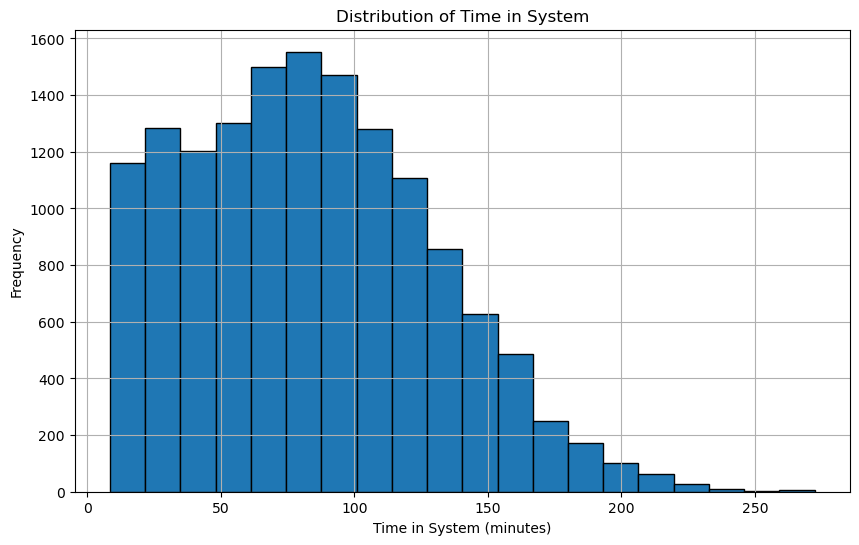

Finished scenario: a4n20d10


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ER_simulation import simulate, process_sim_output
import contextlib
import io

# Define scenarios to explore
scenarios = [
    {
        'num_admin': 2,
        'num_triage_nurses': 10,
        'num_doctors': 5,
        'registration_time_mean': 2.0,
        'registration_time_sd': 0.5,
        'triage_check_mean': 5.0,
        'triage_check_sd': 1.0,
        'triage_time_mean': 5.0,
        'triage_time_sd': 1.0,
        'treatment_time_mean': 60.0,
        'treatment_time_sd': 50.0,
        'discharge_time_mean': 5.0,
        'discharge_time_sd': 1.0,
        'stoptime': 1440,
        'num_reps': 50,
        'seed': 4470,
        'output_path': 'output',
        'scenario': 'baseline',
        'quiet': True
    },
    {
        'num_admin': 4,
        'num_triage_nurses': 20,
        'num_doctors': 10,
        'registration_time_mean': 2.0,
        'registration_time_sd': 0.5,
        'triage_check_mean': 5.0,
        'triage_check_sd': 1.0,
        'triage_time_mean': 5.0,
        'triage_time_sd': 1.0,
        'treatment_time_mean': 60.0,
        'treatment_time_sd': 50.0,
        'discharge_time_mean': 5.0,
        'discharge_time_sd': 1.0,
        'stoptime': 1440,
        'num_reps': 50,
        'seed': 4470,
        'output_path': 'output',
        'scenario': 'a4n20d10',
        'quiet': True
    },
    # Add more scenarios here as needed
]

# Function to run simulation for each scenario
def run_simulation(scenario):
    num_reps = scenario['num_reps']
    output_dir = Path.cwd() / scenario['output_path']
    output_dir.mkdir(parents=True, exist_ok=True)

    # Run simulations with suppressed output
    for i in range(1, num_reps + 1):
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            simulate(scenario, i)
    
    # Consolidate patient logs and compute summary stats
    patient_log_stats = process_sim_output(output_dir, scenario['scenario'])
    
    # Print out summary statistics
    print(f"\nScenario: {scenario['scenario']}")
    pd.set_option("display.precision", 3)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)
    print(patient_log_stats['patient_log_rep_stats'])
    print(patient_log_stats['patient_log_ci'])
    
    # Read patient log data from CSV
    patient_log_file = output_dir / f"consolidated_ER_patient_log_{scenario['scenario']}.csv"
    patient_log_df = pd.read_csv(patient_log_file)
    
    # Calculate and print 95th percentile of time in system
    percentile_95 = patient_log_df['time_in_system'].quantile(0.95)
    print(f"95th percentile of time in system: {percentile_95:.1f} mins")
    
    # Plot histogram of time in system
    plt.figure(figsize=(10, 6))
    plt.hist(patient_log_df['time_in_system'], bins=20, edgecolor='black')
    plt.title('Distribution of Time in System')
    plt.xlabel('Time in System (minutes)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Optionally save configuration file
    save_config_file(scenario)

# Function to save configuration file
def save_config_file(scenario):
    config_fn = f"input/{scenario['scenario']}.cfg"
    Path(config_fn).parent.mkdir(parents=True, exist_ok=True)
    
    with open(config_fn, "w") as config_file:
        for key, value in scenario.items():
            if key != 'quiet':
                config_file.write(f"--{key} {value}\n")
            else:
                if value:
                    config_file.write(f"--{key}\n")

# Run simulations for each scenario
for scenario in scenarios:
    print(f"Running scenario: {scenario['scenario']}")
    run_simulation(scenario)
    print(f"Finished scenario: {scenario['scenario']}")

# We can see for the baseline model 95th percentile of time in system: 1028.1 mins. This is inline with what currently we see at the ER. However lets assume scenario a4n20d10 where we admins are 4, nurses 20 and doctors 10. 
# In the second scenario we can see the time has reduced to 164 min for 95th percentile of the time. This is how the time can be effectively reduced for the patients. 